/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


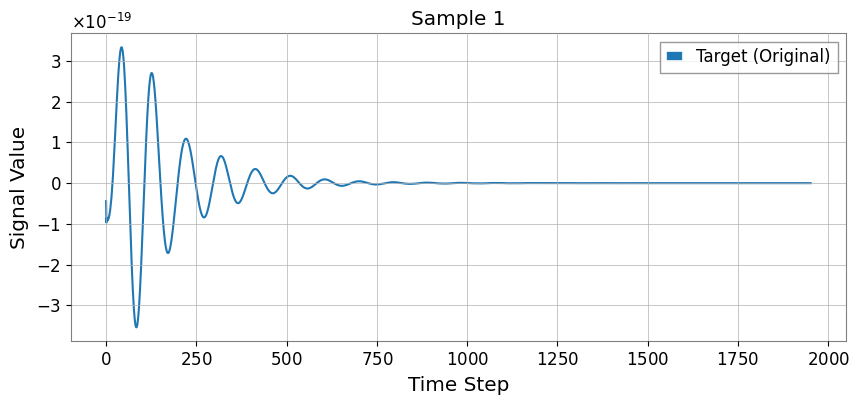

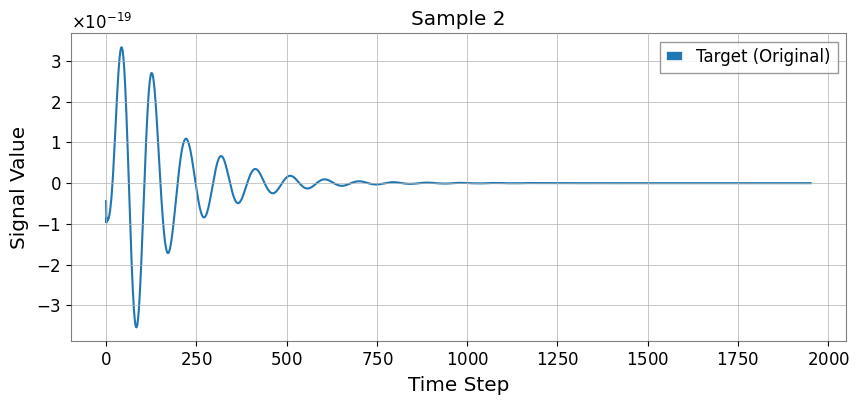

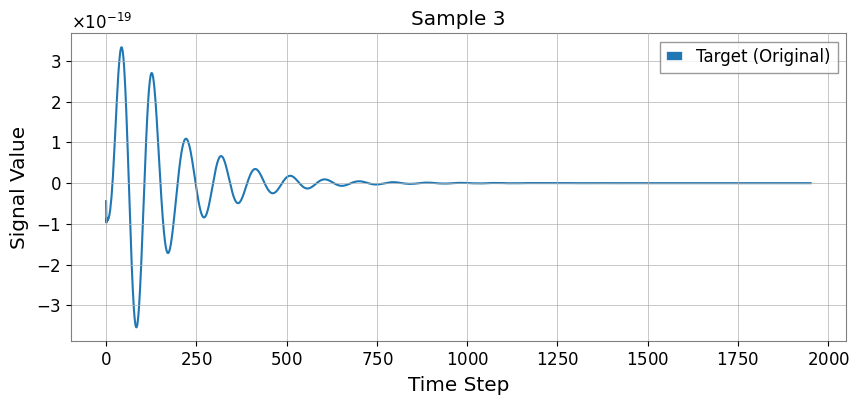

In [1]:
from config.config import Config
import numpy as np
from data.data_generation import generate_data_with_noise
import matplotlib.pyplot as plt

num_samples_to_plot = 3
signals, noises,datas,conditions = generate_data_with_noise(
        num_samples=num_samples_to_plot
    )

targets=signals
# 要绘制的样本数量
for i in range(num_samples_to_plot):
    plt.figure(figsize=(10, 4))
    #plt.plot(inputs[i], label='Input (Masked)')
    plt.plot(targets[i][2048:4000], label='Target (Original)')
    #plt.plot(noises[i][2048:2200], label='Noise')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()
 

In [2]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD


In [3]:
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD

In [1]:
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset,GWSignalWithNoiseDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask_with_noise
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD


 

# 生成训练集数据
#freq_ifft = np.arange(Config.f_in,Config.fout,Config.f_step)

signal_length=Config.signal_length
gap_size = signal_length//Config.signal_to_gap_length_ratio


data = np.load('data/signal_data_with_noise.npz')
#data = np.load('data/test_signal_data.npz')
signals = data['signals']
noises=data['noises']
datas=data['datas']
conditions = data['conditions']
#signal,condition=generate_data(1)
# signals=[]
# signal=signal.transpose(0,1)
# print(signal.shape)
# for _ in range(Config.num_samples):
    
#     signals.append(signal)

# #masked_signals = data['masked_signals']

# conditions=[]
# print(condition.shape)
# condition=condition.transpose(1,0)
# for _ in range(Config.num_samples):
    
#     conditions.append(condition)


#数据预处理
#n_signals,mean,std=normalize(signals)
signals = torch.tensor(signals, dtype=torch.float32)
print(len(signals[0]))
masks = generate_continuous_mask_with_noise(signals.size(0), len(signals[0]),signal_length, gap_size)
masked_signals = []
masked_datas=[]
signals_copy=signals
datas_copy=datas
signals_copy,_,_=normalize(signals_copy)
datas_copy,_,_=normalize(datas_copy)
for i in range(signals.size(0)):
    masked_signal = np.copy(signals[i])
    masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    masked_signals.append(masked_signal)
    masked_data=masked_signal+np.copy(noises[i])
    masked_datas.append(masked_data)
masked_signals,_,_=normalize(masked_signals)
masked_datas,_,_=normalize(masked_datas)

processed_signals = []
processed_masked_signals = []
processed_masked_datas=[]
#白化
whitened_masked_datas=[]
for i in range(masked_datas.size(0)):
    masked_data=np.copy(masked_datas[i])
    whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=PSD_Lisa_no_Response,highpass=2e-3)
    whitened_masked_datas.append(whitened_masked_data)

start=int(1/2*len(whitened_masked_datas[0]))
#取中间保证白化的数据去边缘防止transient
whitened_masked_datas=np.array(whitened_masked_datas)
whitened_masked_datas=whitened_masked_datas[:,start:start+signal_length]
print(signal_length)
print(len(signals[0]))
signals=signals[:,start:start+signal_length]
print(len(signals[0]))
masked_signals=np.array(masked_signals)
masked_signals=masked_signals[:,start:start+signal_length]

for signal,masked_data, masked_signal in zip(signals, whitened_masked_datas,masked_signals):
    # 对原始信号进行小波变换和分段
    print(signal.shape)
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal(transformed_signal)

    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal(transformed_masked_signal)
    
    transformed_datas=wavelet_bandpass(masked_data)
    segment_masked_datas=segment_signal(transformed_datas)

    processed_signals.append(segmented_signal)
    processed_masked_signals.append(segmented_masked_signal)
    processed_masked_datas.append(segment_masked_datas)
    


dataset = GWSignalWithNoiseDataset(signals,processed_signals,processed_masked_signals, processed_masked_datas,conditions)








/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


1056


/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)
/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/torch/csrc/utils/tensor_new.cpp:274.)
  signal=torch.tensor(signal)


NameError: name 'whiten' is not defined

In [ ]:
torch.save(dataset, 'dataset_with_noise_temp.pt')

In [4]:
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model,train_the_model_with_noise
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_dataset = torch.load('dataset_with_noise_temp.pt')
dataset=loaded_dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = Config.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取一个批次的数据
targets,_,_,inputs, conditions = next(iter(train_loader))

#打印形状
print(f'Inputs shape: {inputs.shape}')  
print(f'Targets shape: {targets.shape}')  
print(f'Conditions shape: {conditions.shape}')  

import matplotlib.pyplot as plt

# 可视化第一个批次中的前几个样本
# num_samples_to_plot = 3  # 要绘制的样本数量
# for i in range(num_samples_to_plot):
#     plt.figure(figsize=(10, 4))
#     plt.plot(inputs[i].cpu().numpy(), label='Input (Masked)')
#     plt.plot(targets[i].cpu().numpy(), label='Target (Original)')
#     plt.title(f'Sample {i+1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Signal Value')
#     plt.legend()
#     plt.show()

# 定义模型  
model = MaskedConditionalGapFiller().to(device)
train_the_model_with_noise(
    model,
    train_loader,
    val_loader,
    num_epochs=Config.num_epochs,
    learning_rate=Config.learning_rate,
    save_path_with_noise=Config.model_save_path_with_noise,
    device=device,
    save_freq=10
)


KeyboardInterrupt: 

In [ ]:
import torch
from config.config import Config
from utils.mask import generate_continuous_mask_with_noise
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data,generate_data_with_noise
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform,visualize_waveform_with_noise
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 测试阶段

# def estimate_physical_parameters(signal):
signal_length=Config.signal_length
gap_size = signal_length//Config.signal_to_gap_length_ratio
model = MaskedConditionalGapFiller().to(device)
#model_path = '/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/model.pth'
model.load_state_dict(torch.load('./saved_models/model_with_noise_epoch_10.pth'))

# 切换到评估模式
model.eval()

test_num=50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_signals,test_noises,test_datas,  test_conditions = generate_data_with_noise(
        num_samples=test_num
    )
masks=generate_continuous_mask_with_noise(test_num,len(test_signals[0]),signal_length,gap_size)
#n_test_signals,mean_t,std_t=normalize(test_signals)
test_signals_copy=test_signals
test_datas_copy=test_datas
test_noises_copy=test_noises
test_masked_signals_copy=[]
test_masked_datas_copy=[]
for i in range(test_signals_copy.size(0)):
    test_masked_signal_copy = np.copy(test_signals_copy[i])
    test_masked_signal_copy[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    test_masked_signals_copy.append(test_masked_signal_copy)
    test_masked_data_copy=np.copy(test_noises_copy[i])+test_masked_signal_copy
    test_masked_datas_copy.append(test_masked_data_copy)
    
test_signals,mean,std=normalize(test_signals)
#masked_test_signals_tensor = torch.tensor(n_masked_test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#zero_conditions_tensor = torch.zeros((test_signals_tensor.size(0), Config.condition_dim)).to(device)



100%|██████████| 50/50 [00:12<00:00,  3.95it/s]
/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


In [ ]:
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal

test_masked_signals=[]
for i in range(test_signals.size(0)):
    test_masked_signal = np.copy(test_signals[i])
    test_masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    test_masked_signals.append(test_masked_signal)
processed_test_signals = []
processed_test_masked_signals = []
processed_test_masked_datas=[]
for signal, masked_data,masked_signal in zip(test_signals, test_masked_datas_copy,test_masked_signals):
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal(transformed_signal)

    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal(transformed_masked_signal)

    transformed_masked_data=wavelet_bandpass(masked_data)
    segmented_masked_data=segment_signal(transformed_masked_data)

    processed_test_signals.append(segmented_signal)
    processed_test_masked_signals.append(segmented_masked_signal)
    processed_test_masked_datas.append(segmented_masked_data)

# 转换为张量
processed_test_signals_tensor = torch.tensor(processed_test_signals, dtype=torch.float32).to(device)
processed_test_masked_signals_tensor = torch.tensor(processed_test_masked_signals, dtype=torch.float32).to(device)
processed_test_masked_datas_tensor=torch.tensor(processed_test_masked_datas,dtype=torch.float32).to(device)

<class 'numpy.ndarray'>


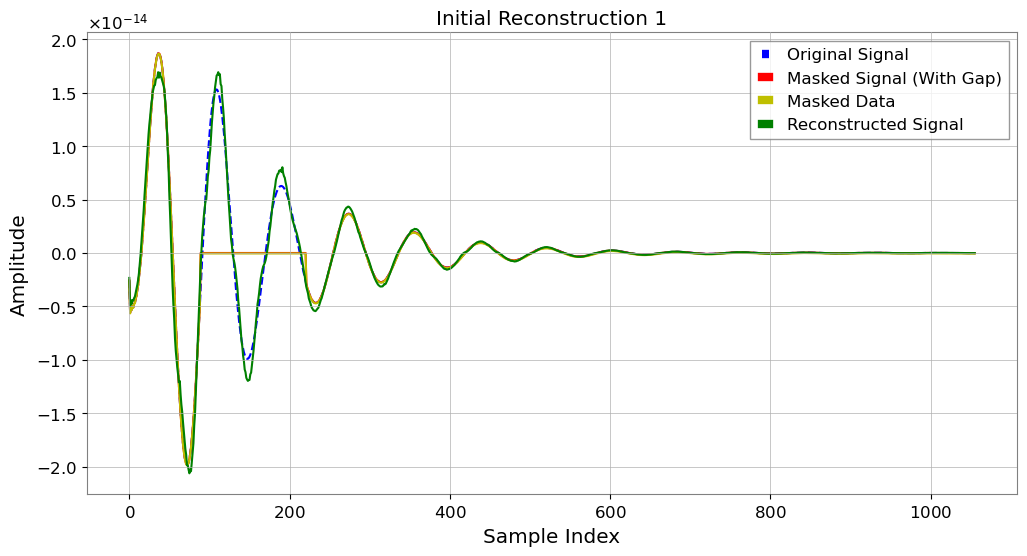

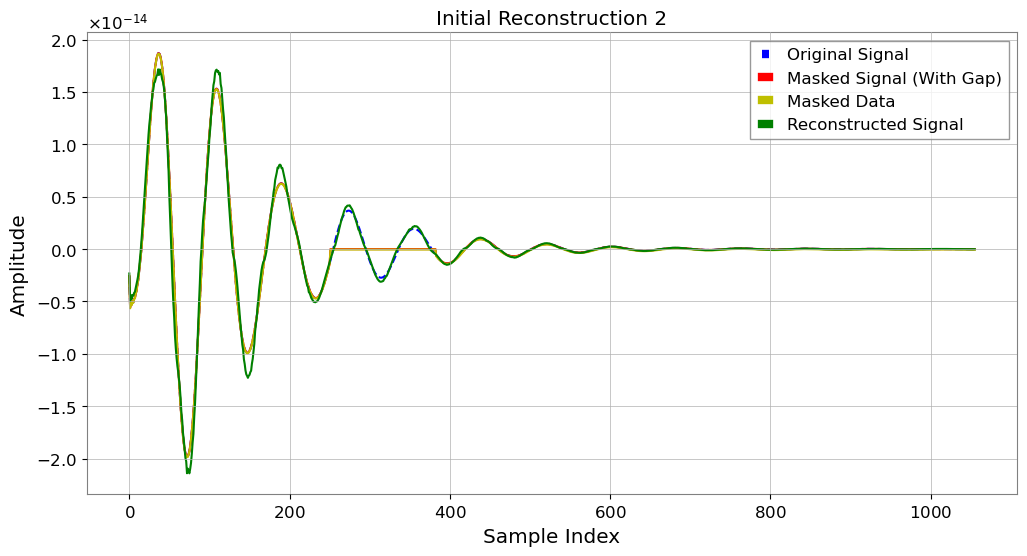

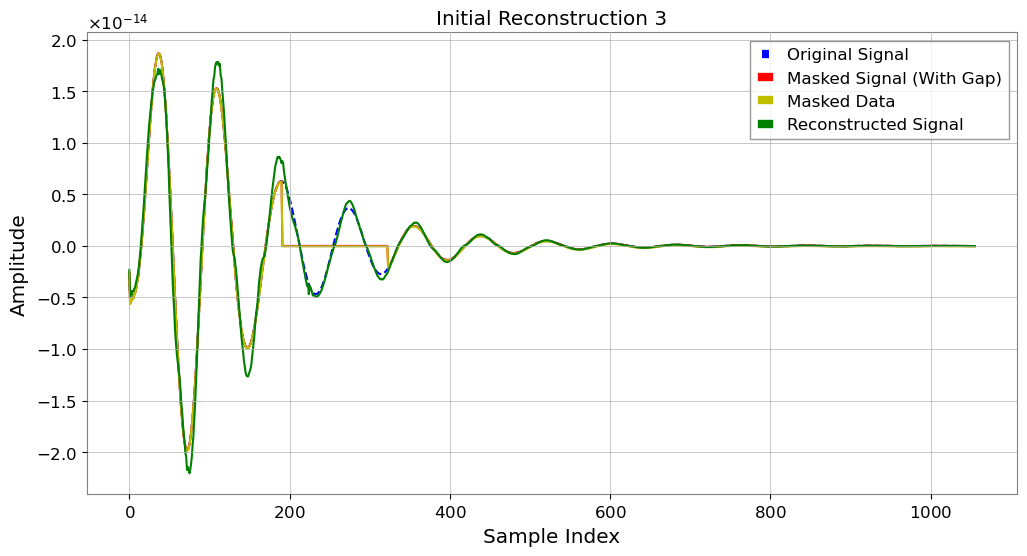

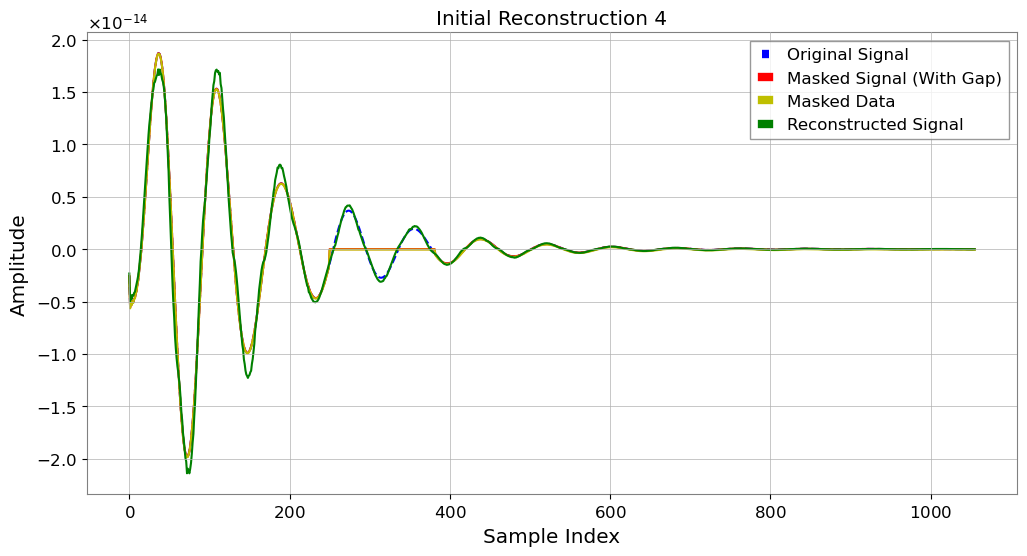

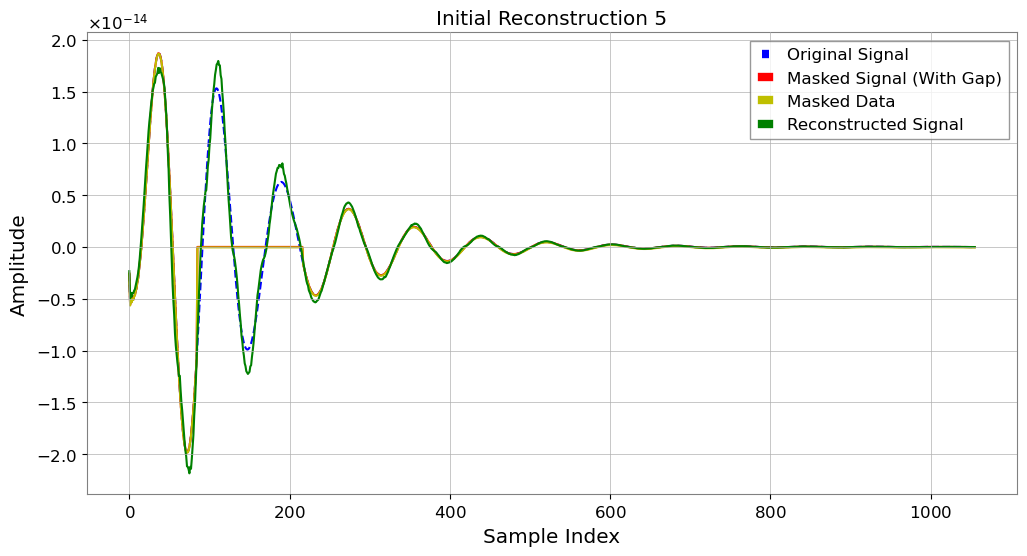

In [ ]:

with torch.no_grad():
    reconstructed_signals_tensor = model(processed_test_masked_signals_tensor)
#    initial_reconstructed_signals = mean_t+std_t*reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
# for i in range(5):
#     print(f"Signal {i}:")
#     print("Original signal contains NaN:", torch.isnan(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains NaN:", torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains NaN:", torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any())

#     print("Original signal contains Inf:", torch.isinf(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains Inf:", torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains Inf:", torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any())

#     # 如果没有NaN或者Inf，才进行可视化
#     if not (torch.isnan(torch.tensor(n_test_signals[i])).any() or
#             torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any() or
#             torch.isinf(torch.tensor(n_test_signals[i])).any() or
#             torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any()):
#         visualize_waveform(
#             n_test_signals[i],
#             masked_test_signals_tensor.cpu().numpy()[i],
#             initial_reconstructed_signals[i],
#             title=f'Initial Reconstruction {i+1}'
#         )
#     else:
#         print(f"Signal {i} contains NaN or Inf, skipping visualization.")
# for i in range(5):
#     print(f"Signal {i}:")
#     print(f"Original signal min: {n_test_signals[i].min()}, max: {n_test_signals[i].max()}")
#     print(f"Masked signal min: {masked_test_signals_tensor.cpu().numpy()[i].min()}, max: {masked_test_signals_tensor.cpu().numpy()[i].max()}")
#     print(f"Reconstructed signal min: {initial_reconstructed_signals[i].min()}, max: {initial_reconstructed_signals[i].max()}")
#print(masks.size(),test_signals.size())
#test_masked_signals=masks.cpu().numpy()*test_signals.cpu().numpy()
#print(masked_test_signals)
# 可视化初步复原结果
std=std.cpu().numpy()
mean=mean.cpu().numpy()
print(type(test_signals.cpu().numpy()))
for i in range(5):
    visualize_waveform_with_noise(
        (test_signals_copy[i].cpu().numpy() ),
        test_masked_signals_copy[i],
        test_masked_datas_copy[i],
        reconstructed_signals_tensor.cpu().numpy()[i][0]*std+mean,
        title=f'Initial Reconstruction {i+1}'
        )

    # 参数估计
estimated_conditions = []
for i in range(reconstructed_signals_tensor.size(0)):
    estimated_params = test_conditions[i]
    estimated_conditions.append(estimated_params)
#estimated_conditions_tensor = torch.tensor(estimated_conditions, dtype=torch.float32).to(device)
estimated_conditions_tensor = torch.tensor(np.array(estimated_conditions), dtype=torch.float32).to(device)

# # 第二次复原：使用估计的条件输入
# with torch.no_grad():
#     final_reconstructed_signals_tensor = model(
#         test_signals_tensor,
#         masks,
#         estimated_conditions_tensor,  # 使用估计的条件输入
#         gap_start
#         )
#     final_reconstructed_signals = final_reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
#     final_reconstructed_signals= std_t*final_reconstructed_signals+mean_t
# # 可视化最终复原结果
# for i in range(5):
#     visualize_waveform(
#         test_signals[i],
#         masked_test_signals[i],
#         final_reconstructed_signals[i],
#         title=f'Final Reconstruction with Estimated Conditions {i+1}'
#         )

In [ ]:
int 1

SyntaxError: invalid syntax (89991222.py, line 1)

In [ ]:
from utils.normalize import normalize
signal=[   ]
a=np.arange(0,11,1)
b=np.arange(0,22,2)
signal.append(a)
signal.append(b)
signal=torch.tensor(signal)
signal = signal.float()
normalized_signal ,mean,std=normalize(signal)


print(normalized_signal)
print(mean)

tensor([[    nan, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071,
         -0.7071, -0.7071, -0.7071],
        [    nan,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,
          0.7071,  0.7071,  0.7071]])
tensor([ 0.0000,  1.5000,  3.0000,  4.5000,  6.0000,  7.5000,  9.0000, 10.5000,
        12.0000, 13.5000, 15.0000])


/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


In [ ]:
import torch

# 假设你的信号数据组是一个二维张量，形状为 (num_signals, signal_length)
# 例如，100个信号，每个信号长度为1000
signals = torch.rand(100, 1000)  # 生成一些随机信号作为示例

# 计算平均信号
mean_signal = signals.mean(dim=0)

# 计算方差信号
std_signal = signals.std(dim=0)

# 对信号进行归一化（减去均值后除以标准差）
normalized_signals = (signals - mean_signal) / std_signal

print("平均信号:", mean_signal.shape)
print("方差信号:", std_signal.shape)


平均信号: torch.Size([1000])
方差信号: torch.Size([1000])


In [ ]:
import torch

# 假设 batch_size=32，seq_len=1000
batch_size = 32
seq_len = 10
gap_size = 2

# 假设 gap_start 是长度为 batch_size 的张量，其中包含每个序列的掩码起始索引
gap_start = torch.randint(0, seq_len - gap_size, (batch_size,))

# 初始化输出张量
output = torch.zeros((batch_size, seq_len, 1))

# 通过广播机制构造索引
row_indices = torch.arange(batch_size).unsqueeze(1)  # [batch_size, 1]
gap_indices = gap_start.unsqueeze(1) + torch.arange(gap_size).unsqueeze(0)  # [batch_size, gap_size]

# 将 1 分配到输出张量中的指定位置
output[row_indices, gap_indices] = 1
print(gap_start,output)

tensor([7, 1, 5, 2, 0, 1, 5, 6, 7, 7, 2, 7, 7, 1, 0, 1, 5, 7, 5, 2, 4, 6, 5, 4,
        1, 3, 1, 0, 1, 4, 6, 5]) tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
       

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# from config.config import Config
# from data.data_generation import generate_varied_sinusoidal_data
# from dataset.dataset import GWSignalDataset
# from model.autoencoder import MaskedConditionalAutoencoder
# from utils.visualization import visualize_waveform

# def main():
#     # 生成测试集数据（包括真实的振幅、频率和相位）
#     test_signals, masked_test_signals, test_conditions = generate_varied_sinusoidal_data(
#         num_samples=5,  # 例如 5 个测试样本
#         signal_length=Config.signal_length,
#         gap_size=Config.gap_size
#     )

#     # 转换为张量并确保维度正确
#     test_signals_tensor = torch.tensor(test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#     masked_test_signals_tensor = torch.tensor(masked_test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#     test_conditions_tensor = torch.tensor(test_conditions, dtype=torch.float32).to(device)

#     # 加载训练好的模型
#     model = MaskedConditionalAutoencoder(
#         input_dim=1,  # 信号的特征维度
#         hidden_dim=Config.hidden_dim,
#         num_layers=Config.num_layers,
#         condition_dim=Config.condition_dim,
#         gap_size=Config.gap_size
#     ).to(device)

#     model.load_state_dict(torch.load(Config.model_save_path))
#     model.eval()  # 设置模型为评估模式

#     # 使用真实参数进行复原
#     with torch.no_grad():
#         reconstructed_signals_tensor = model(
#             masked_test_signals_tensor,
#             torch.ones_like(masked_test_signals_tensor).to(device),
#             test_conditions_tensor  # 使用真实的条件输入
#         )
#         reconstructed_signals = reconstructed_signals_tensor.cpu().squeeze(-1).numpy()

#     # 可视化结果
#     for i in range(5):
#         visualize_waveform(
#             test_signals[i],
#             masked_test_signals[i],
#             reconstructed_signals[i],
#             title=f'Test Signal Reconstruction {i+1} with Real Parameters'
#         )

# if __name__ == "__main__":
#     # 检查是否有可用的GPU
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f'Using device: {device}')

#     main()
